### Kickstart RBM Notebook
- Using an RBM implementation found on github, we perform some preliminary tasks

In [1]:
import os
os.chdir("..")

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import numpy as np
import re 

from src.rbm_example import RBM
import pandas as pd

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_validate, ParameterGrid

import time
from datetime import datetime

In [11]:
def title_ticks_ecc(title, xlabel, ylabel, new_fig= True , figsize= (10,6), title_size=18):
    if new_fig== True:
        plt.figure(figsize=figsize)
        
    plt.title(title, color= 'xkcd:pale red', fontsize= title_size, pad= 13, fontweight= 'bold')
    plt.xlabel(xlabel, color='xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.ylabel(ylabel, color= 'xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.xticks(fontsize=12, color= 'xkcd:cadet blue')
    plt.yticks(fontsize=12, color= 'xkcd:cadet blue')

In [13]:
def reduced_models_lasso(values_C, 
                         train, 
                         ytrain, 
                         random_state=42, 
                         min_n_feats=12, 
                         max_n_feats=70,
                         solver= 'liblinear'):
    
        """
        INPUTS:
           values_C: list or array of C values to try
           train and test: train and test dataset to use, all numerical (cat variables must be encoded)
           random_state: initialization for the minimization problem

           OUTPUT:
           Data frame having for each row the chosen C value, the number of features selected and the list of those"""

        X_train = train
        values_C= [round(val, 5) for val in values_C] ## rounding it to 5 decimals
        #################################################

        reduced_lasso = {}
        len_val_C = 0

        for c in values_C:
                lasso = SelectFromModel(
                        LogisticRegression(C=c, penalty='l1', solver= solver, random_state=random_state))
                lasso.fit(X_train, ytrain)
                feats = list(X_train.columns[lasso.get_support()])
                reduced_lasso[c] = [sum(lasso.get_support()), feats]

                if len(feats) != X_train.shape[1]:
                        len_val_C += 1

        n_feats = [reduced_lasso[c][0] for c in values_C]
        list_feats = [reduced_lasso[c][1] for c in values_C]

        reduced_lasso = pd.DataFrame(n_feats, columns=['n_feats_selected'], index=values_C)
        reduced_lasso['list_features'] = list_feats
        final_index = reduced_lasso[['n_feats_selected']].drop_duplicates(keep='first').index
        reduced_lasso = reduced_lasso.loc[final_index]
        reduced_lasso = reduced_lasso[reduced_lasso['n_feats_selected'] > 2]

        print('Initial features =', X_train.shape[1])

        reduced_lasso = reduced_lasso[(reduced_lasso['n_feats_selected'] > min_n_feats) & (
                reduced_lasso['n_feats_selected'] < max_n_feats)]

        return reduced_lasso

In [24]:
def run_model_no_cv(estimator, X_train, X_test, ytrain, ytest, param_grid=None,
                    print_model=True):

        """HIGH LEVEL EXPLANATION:
        to be stick to US procedure, we have to select parameters this way: for each parameters combination, you see the Train AUC and Test AUC,
        then you choose the best model which has a sufficient small gap (like 1% or 2% difference).
        The same function with CROSS VALIDATION is given after.

        This function allows to just set a parameter grid and the model which is wanted to use and returns Train AUC and Test AUC for each iteration,
        specifying the current parameters.

        INPUT PARAMETERS:
                estimator: classifier which is wanted to use
                X_train, X_test: train and test data, without NA values and categorical features and scaled if necessary.
                param_grid: dictionary of parameters
                print_model: [True, False]. If True, at each iteration, the model is returned. It just helps to verify whether at each iteration the parameters are chaning

        OUTPUT:
               a dataframe with all the combinations of parameters with respective Train and Test AUC scores, plus the ROC plots
               The decision of the "best" parameters has to be taken manually looking at the results

        EXAMPLE USAGE:
                rf= RandomForestClassifier(n_estimators= 10, criterion= 'gini', random_state=0, class_weight= 'balanced')

                param_rf= {
                    "criterion": ['gini'],
                    "n_estimators" : [300],
                    "min_impurity_decrease" :  [1e-03, 1e-06],
                    "min_samples_leaf": [20, 40],
                    "max_depth": [3, 6] }

                best_rf = run_model_no_cv(estimator=rf, X_train= final_train, X_test= final_test, param_grid= param_rf)  #best_rf is a dataframe

        """

        print('\033[1m Initial X_train e X_test shapes are: ', X_train.shape, X_test.shape, '\033[0m \n')
        temp = time.time()


        if param_grid is None:

                estimator.fit(X_train, ytrain, )

                preds = estimator.predict(X_test)
                print('execution time (min)=', round((time.time() - temp) / 60, 1), ' finished at ', datetime.today())
                #summary_classifier(estimator, X_train, ytrain, ytest, preds)

                proba_train_y = estimator.predict_proba(X_train)
                proba_test_y = estimator.predict_proba(X_test)

                roc_auc_test = roc_auc_score(ytest, proba_test_y )
                roc_auc_train = roc_auc_score(ytrain, proba_train_y)
                fpr, tpr, _ = roc_curve(ytest, proba_test_y )
                fpr_tr, tpr_tr, _ = roc_curve(ytrain, proba_train_y)

                title_ticks_ecc('Receiver Operating Characteristic', 'True Positive Rate', 'False Positive Rate',
                                figsize=(10, 6))
                plt.plot(fpr, tpr, label='Test AUC ROC = {0}'.format(round(roc_auc_test, 4)))
                plt.plot(fpr_tr, tpr_tr, label='Train AUC = {0}'.format(round(roc_auc_train, 4)))
                plt.legend(loc='lower right', fontsize=10)
                plt.plot([0, 1], [0, 1], 'r--')
                plt.close()

                return estimator

        else:
                # print(X_train.columns)
                models = {}
                iteration = 1

                for diz_params in list(ParameterGrid(param_grid)):
                        print('\n\t \033[1mITERATION {}/{} \033[0m'.format(iteration,
                                                                           len(list(ParameterGrid(param_grid)))))
                        print('\t Current Grid of Parameters is {}'.format(diz_params))

#                         if catb == True:
#                                 est = cb.CatBoostClassifier()
#                                 est.set_params(**diz_params)
#                                 est.fit(X_train, ytrain, cat_features=X_train.select_dtypes(include=object).columns)
#                         else:
                        est = estimator.set_params(**diz_params)
                        est.fit(X_train, ytrain)

                        pred_train = est.predict_proba(X_train)
                        pred_test = est.predict_proba(X_test)

                        roc_train = float(round(roc_auc_score(ytrain, pred_train[:, 1]), 4))
                        roc_test = float(round(roc_auc_score(ytest, pred_test[:, 1]), 4))
                        print('\n\033[1mROC Train is {a}, ROC Test is {b}\033[0m'.format(a=roc_train,
                                                                                         b=roc_test))

                        degree_overfitting = float((roc_train - roc_test) * 100)

                        models[iteration] = {}

                        if print_model == True:
                                print(est)

                        models[iteration]['diz_params'] = diz_params
                        models[iteration]['degree_overfitting(%)'] = degree_overfitting
                        models[iteration]['Train_AUC']= roc_train
                        models[iteration]['Test_AUC']= roc_test
                        # models[iteration]['est']= est

                        iteration += 1
                        del est

        models = pd.DataFrame(models).T

        for col in models.columns:
                try:
                        models[col] = models[col].astype(float)
                except:
                        pass

        print('execution time (min)=', round((time.time() - temp) / 60, 1), ' finished at ', datetime.today())
        return models.sort_values(by='Test_AUC', ascending=False)

In [3]:
import os
os.getcwd()

'/home/hadoop/dsp-non-addressable-model'

In [10]:
!!ls ./setup

['bootstrap_script.sh',
 'create_cluster.sh',
 'create_modeling_cluster.sh',
 'download_data.sh',
 'download_modeling_data.sh',
 'download_raw_clientfile.sh',
 'limits.conf',
 'md5_match_sample.csv',
 'non_md5match_sample.csv']

In [12]:
pwd

'/home/hadoop/dsp-non-addressable-model'

In [4]:
df = \
  pd.read_csv("./setup/md5_match_sample.csv", 
              nrows=200000, 
              na_values=['-99', '\\N', '\\\\N',
                         'Missing', 'missing', 'NA',
                          '?', '.', 'NULL', '', ' '])

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3777,3783,3784,3786,3787,3788,3790,3875,3879,3885) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Naive Preprocessing Code
- While we should update this later to create a stronger dataset, I did the following to filter out continous variables and get us a binary dataset. Additinoally, I remove all md5 features 
    - strip cols of "'' 
    - remove explicit identifier columns
    - extract binary features
        - to mitigate issues with null vals/continuous variables i simply check that the value in the df == 1
    - drop all zero columns
        - this also will make sure all of our features are binary
    - **remove md5 features**
        - for a fraction of records we will make the md5 features null



In [5]:
def preprocess(df, null_frac=.7):
    return \
      df.pipe(strip_cols) \
        .pipe(drop_unnecessary_cols) \
        .pipe(naive_extract_binary_features) \
        .pipe(drop_all_zero_cols) \
        .pipe(shuffle) \
        .astype(np.float32)
        #.pipe(remove_md5_features, frac=null_frac) \ we are not removing them now
        #.pipe(shuffle) \
        
def strip_cols(df):
    df.columns = [x.replace("'", "") for x in df.columns]
    return df

def drop_unnecessary_cols(df):
    cols_to_drop = ['RFI', 'PROFILE_ID', 'PASZIPCODE','SHA_256','EMAIL_MD5','TU_MATCH_FLAG']
    return df.drop(columns=cols_to_drop)

def naive_extract_binary_features(df):
    return (df == 1).astype(int)

def drop_all_zero_cols(df):
    cols_with_all_zeros = \
      (df.sum() == 0).loc[lambda x: x == True] \
      .index
    return df.drop(columns=cols_with_all_zeros)

def shuffle(df):
    return df.sample(frac=1) \
             .reset_index(drop=True)

def remove_md5_features(df, frac=.7):
    """for a fraction of the records, we make all the md5 features 0"""
    x_columns = [x for x in df.columns if x != 'label']
    
    non_md5_features = [x for x in x_columns if not re.match("\d{1,}", x)]
    null_records = int(len(df) * frac)
    now_null_df = df.iloc[:null_records] \
                    .assign(**{ftr: 0 for ftr in non_md5_features})
    return \
     pd.concat([now_null_df, df.iloc[null_records:]], axis='rows')


#compare to standard logistic regression on this set

### Creating Pytorch Dataset
- Pytorch dataset requires you to implement 
    - `__len__` length of dataset
    - `__getitem_` iterator of how to get the next row in a dataset
    
    
- Here we create two different kinds of datasets
    - `NonAddressableLRDataset`
        - This dataset does not contain the label, which we will then use to run a logistic regression on the latent features
    - `NonAddressableImputationDataset`
        - This dataset does contain the label, and we will make our predictions via reconstruction

In [6]:
class NonAddressableLRDataset(Dataset):
    """Pytorch Dataset WITHOUT LABEL"""
    def __init__(self, df, transform=None):
        df = df.reset_index(drop=True)
        self.X = df[[x for x in df.columns if x != 'label']]
        self.Y = df['label']
        self.transform = transform
        self.VISIBLE_UNITS = len(self.X.columns)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        features = torch.tensor(self.X.iloc[idx].values)
        label = torch.tensor(self.Y.iloc[[idx]].values)
        if self.transform is not None:
            features = self.transform(features)
        return features, label
    
class NonAddressableImputationDataset(Dataset):
    """The same as the previous class, however, we have label"""   
    def __init__(self, df, transform=None):
        df = df.reset_index(drop=True)
        self.X = df
        self.transform = transform
        self.VISIBLE_UNITS = len(self.X.columns)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        features = torch.tensor(self.X.iloc[idx].values)
        
        if self.transform is not None:
            features = self.transform(features)
            
        return features
    
def plot_loss(losses):
    pd.DataFrame(losses, columns=['epoch', 'loss']) \
      .set_index("epoch") \
      .plot(kind='line')   

### Training Functions for LR RBM
- Here we are training RBM and then running a logistic regression on the latent features so we do not use the label in our training

`train_lr_RBM`
- Trains RBM in the case that we are excluding the label

`generate_latent_features`
- Performs a forward pass on our train/test data and returns the latent features

In [7]:
def train_lr_RBM(train_loader,
                 VISIBLE_UNITS,
                 BATCH_SIZE=64,
                 HIDDEN_UNITS=128, 
                 CD_K=1, 
                 EPOCHS=60,
                 use_cuda=False):
    rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K, use_cuda=CUDA)
    loss = []
    for epoch in range(EPOCHS):
        epoch_error = 0.0
    
        for batch, _ in train_loader:
            batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    
            if CUDA:
                batch = batch.cuda()
    
            batch_error = rbm.contrastive_divergence(batch)
    
            epoch_error += batch_error
    
        print('Epoch Error (epoch=%d): %.4f' % (epoch, epoch_error))
        loss.append([epoch, epoch_error.item()])
    return rbm, loss
    
def generate_latent_features(rbm,
                             train_dataset,
                             test_dataset,
                             train_loader,
                             test_loader,
                             HIDDEN_UNITS=128):
    VISIBLE_UNITS = train_dataset.VISIBLE_UNITS
    train_features = np.zeros((len(train_dataset), HIDDEN_UNITS))
    train_labels = np.zeros(len(train_dataset))
    test_features = np.zeros((len(test_dataset), HIDDEN_UNITS))
    test_labels = np.zeros(len(test_dataset))
    
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    
        if CUDA:
            batch = batch.cuda()
    
        train_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
        train_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy().flatten()
    
    for i, (batch, labels) in enumerate(test_loader):
        batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    
        if CUDA:
            batch = batch.cuda()
    
        test_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
        test_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy().flatten()
    
    return train_features, train_labels, test_features, test_labels

### Data Preprocessing

In [8]:
preprocessed_DF = \
  df.pipe(preprocess).astype(np.float32)
X = list([x for x in preprocessed_DF.columns if x != "label"])
Y = "label"
md5_features = [x for x in preprocessed_DF.columns if re.match("\d{1,}", x)]
non_md5_features = [x for x in preprocessed_DF.columns if not re.match("\d{1,}", x) and x != "label"]

In [20]:
df['label'].sum()

61841

### Training RBM for the LR case
- I did not tune hyperparameters yet

Epoch Error (epoch=0): 30298506.0000
Epoch Error (epoch=1): 14565626.0000
Epoch Error (epoch=2): 13893167.0000
Epoch Error (epoch=3): 13474336.0000
Epoch Error (epoch=4): 13186837.0000
Epoch Error (epoch=5): 12980025.0000
Epoch Error (epoch=6): 12845203.0000
Epoch Error (epoch=7): 12734334.0000
Epoch Error (epoch=8): 12646727.0000
Epoch Error (epoch=9): 12573965.0000
Epoch Error (epoch=10): 12514105.0000
Epoch Error (epoch=11): 12452686.0000
Epoch Error (epoch=12): 12396238.0000
Epoch Error (epoch=13): 12343818.0000
Epoch Error (epoch=14): 12291966.0000
Epoch Error (epoch=15): 12248524.0000
Epoch Error (epoch=16): 12210264.0000
Epoch Error (epoch=17): 12174630.0000
Epoch Error (epoch=18): 12142232.0000
Epoch Error (epoch=19): 12114341.0000
Epoch Error (epoch=20): 12085878.0000
Epoch Error (epoch=21): 12063129.0000
Epoch Error (epoch=22): 12041521.0000
Epoch Error (epoch=23): 12022449.0000
Epoch Error (epoch=24): 12003616.0000
Epoch Error (epoch=25): 11987260.0000
Epoch Error (epoch=26)

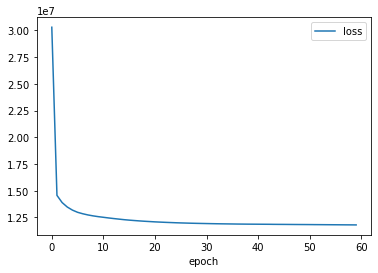

In [21]:
#### Hyperparameters
BATCH_SIZE = 64
HIDDEN_UNITS = 128
CD_K = 1
EPOCHS = 60
CUDA = False

train, test = train_test_split(preprocessed_DF, test_size=.4)

train_dataset = NonAddressableLRDataset(train)
test_dataset = NonAddressableLRDataset(test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

rbm, losses = train_lr_RBM(train_loader, 
                           train_dataset.VISIBLE_UNITS, EPOCHS = EPOCHS , CD_K = CD_K, use_cuda = CUDA)
plot_loss(losses)

In [22]:
train_features, train_labels, test_features, test_labels = \
  generate_latent_features(rbm,
                           train_dataset,
                           test_dataset,
                           train_loader,
                           test_loader)

### Preliminary Evaluation for the LR case
- In order to get an idea of the performance w/ this data 
    - a classifier w the latent features from the RBM
    - a classifier on the raw training features 
 
#### Notes
- I believe LogisticRegression in sklearn defaults doing L2 penalty, so perhaps the delta in results between the two is due to l2 being better suited for the lower dimensional latent // continous feautres than the high dimensional sparse matrix that we started with


In [36]:
pd.DataFrame(train_features).head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,9.910194e-01,0.000306,0.998160,0.999808,0.000001,0.062660,0.999400,6.051660e-07,0.999218,9.887495e-01,...,0.000602,0.000259,9.910758e-01,0.996380,0.060530,0.000023,0.000802,3.291232e-10,0.999156,0.999972
1,9.173273e-01,0.999841,0.842315,0.999846,0.999850,0.993182,0.991385,9.993092e-01,0.990580,9.298694e-04,...,0.999251,0.999412,9.096835e-01,0.943529,0.998246,0.999865,0.990495,9.983254e-01,0.989573,0.995251
2,9.648160e-01,0.866365,0.029612,0.000288,0.809642,0.999986,0.997936,9.970183e-01,0.997478,9.900954e-01,...,0.000778,0.999340,9.656271e-01,0.981899,0.003091,0.003208,0.981044,1.564270e-06,0.997203,0.999778
3,4.336944e-09,0.999086,0.000009,0.999354,0.999245,0.978525,0.000538,9.975210e-01,0.000504,2.931903e-10,...,0.999019,0.998785,3.771101e-09,0.000118,0.997536,0.998807,0.999945,9.967191e-01,0.000424,0.997343
4,9.522420e-01,0.999415,0.719807,0.000378,0.999518,0.999991,0.997145,8.787863e-01,0.996644,9.929014e-01,...,0.999207,0.997683,9.519899e-01,0.970967,0.997346,0.999901,0.000750,9.258445e-02,0.996303,0.999273


In [31]:
train_features.shape, train_labels.shape

((120000, 128), (120000,))

In [42]:
pd.DataFrame(train_features).describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,120000.000000,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,...,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,120000.000000
mean,9.033561e-01,6.348078e-01,7.125301e-01,5.455635e-01,6.641388e-01,0.550037,9.764564e-01,5.338461e-01,9.757876e-01,8.587283e-01,...,7.672417e-01,7.096099e-01,9.022319e-01,9.416335e-01,5.764372e-01,6.417290e-01,6.779555e-01,3.917399e-01,9.752954e-01,0.990705
std,2.331182e-01,4.534950e-01,3.607989e-01,4.968136e-01,4.316803e-01,0.479161,1.390873e-01,4.706822e-01,1.397909e-01,3.065024e-01,...,3.860230e-01,4.156960e-01,2.344344e-01,1.847557e-01,4.772537e-01,4.513941e-01,4.363293e-01,4.664476e-01,1.403415e-01,0.088116
min,2.426757e-13,1.275966e-08,1.955757e-13,4.631989e-07,3.566260e-14,0.000055,1.579571e-08,1.115381e-11,1.321325e-08,2.560094e-12,...,1.051135e-10,3.384914e-10,2.340012e-13,1.016145e-11,4.781780e-09,1.557674e-11,2.066126e-12,4.653072e-14,1.029638e-08,0.000028
25%,9.576712e-01,1.527847e-02,4.768665e-01,9.299605e-04,8.174857e-02,0.022082,9.970088e-01,5.052091e-04,9.965470e-01,9.578173e-01,...,6.795740e-01,2.365637e-01,9.570974e-01,9.764688e-01,2.775765e-03,1.603328e-02,7.066223e-02,1.852675e-07,9.961751e-01,0.999107
50%,9.786124e-01,9.941993e-01,9.220235e-01,9.995912e-01,9.822245e-01,0.991185,9.983859e-01,7.922492e-01,9.980929e-01,9.844503e-01,...,9.978308e-01,9.962118e-01,9.787726e-01,9.874736e-01,9.771563e-01,9.953632e-01,9.794073e-01,3.481912e-03,9.978867e-01,0.999723
75%,9.870144e-01,9.998914e-01,9.814275e-01,9.999000e-01,9.998310e-01,0.999992,9.992296e-01,9.983839e-01,9.990538e-01,9.927348e-01,...,9.995388e-01,9.997169e-01,9.873961e-01,9.938588e-01,9.974900e-01,9.999135e-01,9.887532e-01,9.895194e-01,9.989492e-01,0.999934
max,9.981091e-01,9.999942e-01,9.999406e-01,9.999819e-01,9.999938e-01,1.000000,9.998997e-01,9.998221e-01,9.998659e-01,9.992118e-01,...,9.999920e-01,9.999921e-01,9.981886e-01,9.992176e-01,9.995348e-01,9.999878e-01,9.999994e-01,9.993986e-01,9.998528e-01,0.999999


In [ ]:
# from sklearn.linear_model import LogisticRegressionCV
# searchCV = LogisticRegressionCV(
#         Cs=7
#         ,penalty='l1'
#         ,scoring='roc_auc'
#         ,cv=3
#         ,random_state=42
#         ,max_iter=10000
#         ,fit_intercept=True
#         ,n_jobs = -1
#         ,solver = 'saga'
#     )
# latent_cv = searchCV.fit(train_features, train_labels)
# print(latent_cv.scores_[1].max())

# raw_cv = searchCV.fit(train[X], train[Y])
# print(raw_cv.scores_[1].max())

# md5_features_cv = searchCV.fit(train[md5_features], train[Y])
# print(md5_features_cv.scores_[1].max())

# non_md5_features_cv = searchCV.fit(train[non_md5_features], train[Y])
# print(non_md5_features_cv.scores_[1].max())


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
searchCV = LogisticRegressionCV(
        Cs=5
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=3
        ,random_state=42
        ,max_iter=100
        ,fit_intercept=True
        ,n_jobs = -1
        
    )
latent_cv2 = searchCV.fit(train_features, train_labels)
print(latent_cv2.scores_[1].max())

raw_cv2 = searchCV.fit(train[X], train[Y])
print(raw_cv2.scores_[1].max())

md5_features_cv2 = searchCV.fit(train[md5_features], train[Y])
print(md5_features_cv2.scores_[1].max())

non_md5_features_cv2 = searchCV.fit(train[non_md5_features], train[Y])
print(non_md5_features_cv2.scores_[1].max())

In [ ]:
os.getcwd()

In [ ]:
def save_csv(X, Y, name):
    df = pd.concat([X, Y], axis = 1) 
    df.to_csv(name)
    
    
save_csv(pd.DataFrame(train_features) , pd.DataFrame(train_labels), 'latent_no_0.csv')
save_csv( train[X], train[Y], 'raw_no_0.csv')
save_csv( train[md5_features], train[Y], 'md5_features_no_0.csv')
save_csv( train[non_md5_features], train[Y], 'non_md5_features_no_0.csv')


save_csv(pd.DataFrame(test_features) , pd.DataFrame(test_labels), 'latent_test_no_0.csv')
save_csv( test[X], test[Y], 'raw_test_no_0.csv')
save_csv( test[md5_features], test[Y], 'md5_features_test_no_0.csv')
save_csv( test[non_md5_features], test[Y], 'non_md5_features_test_no_0.csv')


### <center> <font color='orange'> Running RBM on original Dataset

In [9]:
preprocessed_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,z261,z498,z52,z178,z87,z374,z319,z26,z257,z264
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
sample_size= 40000
test_size= 0.25
train_size= 1- test_size

orig_train_sample= preprocessed_DF.sample(sample_size, random_state= 42)


orig_test_sample= orig_train_sample.iloc[int(train_size*sample_size) : ]
orig_train_sample= orig_train_sample.iloc[: int(train_size*sample_size)]


ytrain_sample= orig_train_sample['label']
ytest_sample= orig_test_sample['label']


#### Final Sample Train using all features ####
orig_train_sample.drop('label', axis=1, inplace= True)
orig_test_sample.drop('label', axis=1, inplace= True)


#### Final Sample Train using only MD5 features ####
md5_orig_train_sample= orig_train_sample.drop(md5_features, axis=1)
md5_orig_test_sample= orig_test_sample.drop(md5_features, axis=1)


#### Final Sample Train using only DSP features ####
md5_orig_train_sample= orig_train_sample.drop(non_md5_features, axis=1)
md5_orig_test_sample= orig_test_sample.drop(non_md5_features, axis=1)


orig_train_sample.shape, orig_test_sample.shape, md5_orig_train_sample.shape, md5_orig_test_sample.shape

((30000, 5074), (10000, 5074), (30000, 1418), (10000, 1418))

In [23]:
list_C_parameters =   np.linspace(0.025, 0.06, 5)  #np.arange(0.00125, 0.005, 5)  #list(np.linspace(0.001, 0.125, 4))  # or = [0.00050, 0.00075, 0.00100]

features_selected= reduced_lasso_final= reduced_models_lasso(
                                    values_C= list_C_parameters,
                                    train= orig_train_sample,
                                    ytrain= ytrain_sample,
                                    random_state=42,
                                    min_n_feats= 20,
                                    max_n_feats= 5000,
                                    solver= 'liblinear')    

reduced_lasso_final

Initial features = 5074


,n_feats_selected,list_features
0.02500,119,"[84, 87, 219, 358, 390, 477, 595, 631, 975, 11..."
0.03375,217,"[84, 85, 87, 219, 358, 390, 477, 528, 530, 562..."
0.04250,293,"[84, 85, 87, 128, 219, 358, 390, 477, 528, 530..."
0.05125,388,"[2, 84, 85, 87, 128, 219, 284, 358, 361, 390, ..."
0.06000,478,"[2, 4, 31, 62, 84, 85, 87, 128, 157, 219, 284,..."


In [49]:
### Grid Search without Cross Validation
final_list_C= list(reduced_lasso_final.index)

logi= Pipeline([
      ('lasso', SelectFromModel(LogisticRegression(penalty='l1' ,random_state= 42, 
                                                   class_weight='balanced', solver= 'liblinear',
                                                  max_iter=1000) )), 
      ('clf', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000), )   
                        ])


param_grid_lasso =  [    {
                'lasso__estimator__C': final_list_C,
                 'clf__penalty': ['none'], 
                'clf__solver': ['saga' ],
                'clf__C': [1] # no needed, penalty is always set to 'none' bcs in the end we need to use a simple LR..
                    }  ]


### Without CV
    
    
grid_logistic_no_cv = run_model_no_cv(estimator=logi,
                                        X_train=orig_train_sample, 
                                        X_test= orig_test_sample,
                                        ytrain= ytrain_sample,
                                        ytest= ytest_sample,
                                        param_grid=param_grid_lasso,
                                        print_model=False)
grid_logistic_no_cv

 Initial X_train e X_test shapes are:  (30000, 5074) (10000, 5074)  


	 ITERATION 1/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.025}

ROC Train is 0.6281, ROC Test is 0.5745

	 ITERATION 2/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.03375}

ROC Train is 0.6429, ROC Test is 0.5741

	 ITERATION 3/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.0425}

ROC Train is 0.657, ROC Test is 0.5763

	 ITERATION 4/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.05125}

ROC Train is 0.669, ROC Test is 0.5755

	 ITERATION 5/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.06}

ROC Train is 0.6809, ROC Test is 0.5759
execution time (mi

,diz_params,degree_overfitting(%),Train_AUC,Test_AUC
3,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",8.07,0.6570,0.5763
5,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",10.50,0.6809,0.5759
4,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",9.35,0.6690,0.5755
1,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",5.36,0.6281,0.5745
2,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",6.88,0.6429,0.5741


In [59]:
grid_logistic_no_cv['param_lasso__estimator__C']= \
                    grid_logistic_no_cv['diz_params'].apply(lambda x: x['lasso__estimator__C'] )


final_complete_results= {}  #combining results_grids and features_selected to have a complete summary in one single df

features_selected.index.name= 'param_lasso__estimator__C'
final_complete_results= features_selected.reset_index().merge(grid_logistic_no_cv).sort_values(
                                                                        by= 'Test_AUC', ascending= False)

final_complete_results= final_complete_results[['param_lasso__estimator__C', 'n_feats_selected',
                                                     'Train_AUC','Test_AUC', 'degree_overfitting(%)']]


final_complete_results['features']= 'DSP + MD5'
final_complete_results.set_index('features', inplace= True)

final_complete_results

,param_lasso__estimator__C,n_feats_selected,Train_AUC,Test_AUC,degree_overfitting(%)
features,,,,,
DSP + MD5,0.04250,293,0.6570,0.5763,8.07
DSP + MD5,0.06000,478,0.6809,0.5759,10.50
DSP + MD5,0.05125,388,0.6690,0.5755,9.35
DSP + MD5,0.02500,119,0.6281,0.5745,5.36
DSP + MD5,0.03375,217,0.6429,0.5741,6.88


### <font color='green'> Using only md5 features

In [34]:
list_C_parameters =   np.linspace(0.025, 0.06, 5)  #np.arange(0.00125, 0.005, 5)  #list(np.linspace(0.001, 0.125, 4))  # or = [0.00050, 0.00075, 0.00100]

md5_features_selected= md5_reduced_lasso_final= reduced_models_lasso(
                                    values_C= list_C_parameters,
                                    train= md5_orig_train_sample,
                                    ytrain= ytrain_sample,
                                    random_state=42,
                                    min_n_feats= 20,
                                    max_n_feats= 500,
                                    solver= 'liblinear')    

md5_reduced_lasso_final

Initial features = 1418


,n_feats_selected,list_features
0.02500,86,"[IBE7753, IBE7773, IBE7777, IBE7780, IBE7801, ..."
0.03375,142,"[IBE7746, IBE7753, IBE7754, IBE7773, IBE7777, ..."
0.04250,212,"[IBE7732, IBE7746, IBE7753, IBE7754, IBE7763, ..."
0.05125,266,[IBE2076_IBE_PREMIER_SOCIALCONCERNCAUSESSUPPOR...
0.06000,336,[IBE2076_IBE_PREMIER_SOCIALCONCERNCAUSESSUPPOR...


In [56]:
### Grid Search without Cross Validation
md5_final_list_C= list(md5_reduced_lasso_final.index)

logi= Pipeline([
      ('lasso', SelectFromModel(LogisticRegression(penalty='l1' ,random_state= 42, class_weight='balanced', solver= 'liblinear' ) )), 
      ('clf', LogisticRegression(random_state=42, class_weight='balanced' ), )   
                        ])


md5_param_grid_lasso =  [    {
                'lasso__estimator__C': md5_final_list_C,
                 'clf__penalty': ['none'], 
                'clf__solver': ['saga' ],
                'clf__C': [1] # no needed, penalty is always set to 'none' bcs in the end we need to use a simple LR..
                    }  ]


### Without CV
    
    
md5_grid_logistic_no_cv = run_model_no_cv(estimator=logi,
                                        X_train= md5_orig_train_sample, 
                                        X_test= md5_orig_test_sample,
                                        ytrain= ytrain_sample,
                                        ytest= ytest_sample,
                                        param_grid= md5_param_grid_lasso,
                                        print_model=True)
md5_grid_logistic_no_cv

 Initial X_train e X_test shapes are:  (30000, 1418) (10000, 1418)  


	 ITERATION 1/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.025}

ROC Train is 0.5998, ROC Test is 0.5541
Pipeline(steps=[('lasso',
                 SelectFromModel(estimator=LogisticRegression(C=0.025,
                                                              class_weight='balanced',
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced',
                                    penalty='none', random_state=42,
                                    solver='saga'))])

	 ITERATION 2/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 

,diz_params,degree_overfitting(%),Train_AUC,Test_AUC
5,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",7.35,0.6331,0.5596
4,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",6.94,0.6286,0.5592
3,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",6.24,0.6215,0.5591
2,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",5.89,0.6131,0.5542
1,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",4.57,0.5998,0.5541


In [60]:
md5_grid_logistic_no_cv['param_lasso__estimator__C']= \
                    md5_grid_logistic_no_cv['diz_params'].apply(lambda x: x['lasso__estimator__C'] )


md5_final_complete_results= {}  #combining results_grids and features_selected to have a complete summary in one single df

md5_features_selected.index.name= 'param_lasso__estimator__C'
md5_final_complete_results= md5_features_selected.reset_index().merge(md5_grid_logistic_no_cv).sort_values(
                                                                        by= 'Test_AUC', ascending= False)

md5_final_complete_results= md5_final_complete_results[['param_lasso__estimator__C', 'n_feats_selected',
                                                     'Train_AUC','Test_AUC', 'degree_overfitting(%)']]

md5_final_complete_results


md5_final_complete_results['features']= 'ONLY MD5'
md5_final_complete_results.set_index('features', inplace= True)

md5_final_complete_results

,param_lasso__estimator__C,n_feats_selected,Train_AUC,Test_AUC,degree_overfitting(%)
features,,,,,
ONLY MD5,0.06000,336,0.6331,0.5596,7.35
ONLY MD5,0.05125,266,0.6286,0.5592,6.94
ONLY MD5,0.04250,212,0.6215,0.5591,6.24
ONLY MD5,0.03375,142,0.6131,0.5542,5.89
ONLY MD5,0.02500,86,0.5998,0.5541,4.57


### <font color='blue'> Using only dsp features

In [68]:
list_C_parameters =  np.linspace(0.05, 0.1, 5)  #np.arange(0.00125, 0.005, 5)  #list(np.linspace(0.001, 0.125, 4))  # or = [0.00050, 0.00075, 0.00100]

dsp_features_selected= dsp_reduced_lasso_final= reduced_models_lasso(
                                    values_C= list_C_parameters,
                                    train= dsp_orig_train_sample,
                                    ytrain= ytrain_sample,
                                    random_state=42,
                                    min_n_feats= 20,
                                    max_n_feats= 500,
                                    solver= 'liblinear')    

dsp_reduced_lasso_final

Initial features = 3656


,n_feats_selected,list_features
0.0500,127,"[2, 3, 4, 31, 84, 85, 87, 157, 219, 284, 358, ..."
0.0625,181,"[2, 3, 4, 31, 62, 84, 85, 87, 157, 219, 284, 3..."
0.0750,259,"[1, 2, 4, 31, 61, 62, 84, 87, 128, 157, 195, 2..."
0.0875,342,"[1, 2, 3, 4, 31, 48, 61, 62, 84, 87, 91, 126, ..."
0.1000,412,"[1, 2, 3, 4, 31, 48, 61, 62, 84, 87, 91, 126, ..."


In [71]:
### Grid Search without Cross Validation
dsp_final_list_C= list(dsp_reduced_lasso_final.index)

logi= Pipeline([
      ('lasso', SelectFromModel(LogisticRegression(penalty='l1' ,random_state= 42, class_weight='balanced', solver= 'liblinear' ) )), 
      ('clf', LogisticRegression(random_state=42, class_weight='balanced' ), )   
                        ])


dsp_param_grid_lasso =  [    {
                'lasso__estimator__C': dsp_final_list_C,
                 'clf__penalty': ['none'], 
                'clf__solver': ['saga' ],
                'clf__C': [1] # no needed, penalty is always set to 'none' bcs in the end we need to use a simple LR..
                    }  ]


### Without CV
    
    
dsp_grid_logistic_no_cv = run_model_no_cv(estimator=logi,
                                        X_train= dsp_orig_train_sample, 
                                        X_test= dsp_orig_test_sample,
                                        ytrain= ytrain_sample,
                                        ytest= ytest_sample,
                                        param_grid= dsp_param_grid_lasso,
                                        print_model=True)
dsp_grid_logistic_no_cv

 Initial X_train e X_test shapes are:  (30000, 3656) (10000, 3656)  


	 ITERATION 1/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.05}


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC Train is 0.6058, ROC Test is 0.5463
Pipeline(steps=[('lasso',
                 SelectFromModel(estimator=LogisticRegression(C=0.05,
                                                              class_weight='balanced',
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced',
                                    penalty='none', random_state=42,
                                    solver='saga'))])

	 ITERATION 2/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.0625}


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC Train is 0.6232, ROC Test is 0.5509
Pipeline(steps=[('lasso',
                 SelectFromModel(estimator=LogisticRegression(C=0.0625,
                                                              class_weight='balanced',
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced',
                                    penalty='none', random_state=42,
                                    solver='saga'))])

	 ITERATION 3/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.075}


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC Train is 0.6337, ROC Test is 0.5502
Pipeline(steps=[('lasso',
                 SelectFromModel(estimator=LogisticRegression(C=0.075,
                                                              class_weight='balanced',
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced',
                                    penalty='none', random_state=42,
                                    solver='saga'))])

	 ITERATION 4/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.0875}


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC Train is 0.6433, ROC Test is 0.5474
Pipeline(steps=[('lasso',
                 SelectFromModel(estimator=LogisticRegression(C=0.0875,
                                                              class_weight='balanced',
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced',
                                    penalty='none', random_state=42,
                                    solver='saga'))])

	 ITERATION 5/5 
	 Current Grid of Parameters is {'clf__C': 1, 'clf__penalty': 'none', 'clf__solver': 'saga', 'lasso__estimator__C': 0.1}


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC Train is 0.6502, ROC Test is 0.5494
Pipeline(steps=[('lasso',
                 SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                              class_weight='balanced',
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced',
                                    penalty='none', random_state=42,
                                    solver='saga'))])
execution time (min)= 2.3  finished at  2020-08-24 18:40:27.313166


,diz_params,degree_overfitting(%),Train_AUC,Test_AUC
2,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",7.23,0.6232,0.5509
3,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",8.35,0.6337,0.5502
5,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",10.08,0.6502,0.5494
4,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",9.59,0.6433,0.5474
1,"{'clf__C': 1, 'clf__penalty': 'none', 'clf__so...",5.95,0.6058,0.5463


In [72]:
dsp_grid_logistic_no_cv['param_lasso__estimator__C']= \
                    dsp_grid_logistic_no_cv['diz_params'].apply(lambda x: x['lasso__estimator__C'] )


dsp_final_complete_results= {}  #combining results_grids and features_selected to have a complete summary in one single df

dsp_features_selected.index.name= 'param_lasso__estimator__C'
dsp_final_complete_results= dsp_features_selected.reset_index().merge(dsp_grid_logistic_no_cv).sort_values(
                                                                        by= 'Test_AUC', ascending= False)

dsp_final_complete_results= dsp_final_complete_results[['param_lasso__estimator__C', 'n_feats_selected',
                                                     'Train_AUC','Test_AUC', 'degree_overfitting(%)']]


dsp_final_complete_results['features']= 'ONLY DSP'
dsp_final_complete_results.set_index('features', inplace= True)

dsp_final_complete_results

,param_lasso__estimator__C,n_feats_selected,Train_AUC,Test_AUC,degree_overfitting(%)
features,,,,,
ONLY DSP,0.0625,181,0.6232,0.5509,7.23
ONLY DSP,0.0750,259,0.6337,0.5502,8.35
ONLY DSP,0.1000,412,0.6502,0.5494,10.08
ONLY DSP,0.0875,342,0.6433,0.5474,9.59
ONLY DSP,0.0500,127,0.6058,0.5463,5.95


### Training RBM, Reconstruction Case
- Here we are training the RBM with the label, and then using the imputed features

In [61]:
def train_reconstruction_RBM(train_loader,
                             VISIBLE_UNITS,
                             BATCH_SIZE=64,
                             HIDDEN_UNITS=128, 
                             CD_K=1, 
                             EPOCHS=60,
                             use_cuda=False):
    rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K, use_cuda=CUDA)
    loss = []
    for epoch in range(EPOCHS):
        epoch_error = 0.0
    
        for batch in train_loader:
            batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    
            if CUDA:
                batch = batch.cuda()
    
            batch_error = rbm.contrastive_divergence(batch)
    
            epoch_error += batch_error
    
        print('Epoch Error (epoch=%d): %.4f' % (epoch, epoch_error))
        loss.append([epoch, epoch_error.item()])
    return rbm, loss

def generate_reconstruction(rbm,
                             test_dataset,
                             test_loader,
                             HIDDEN_UNITS=128):
    VISIBLE_UNITS = train_dataset.VISIBLE_UNITS
    train_features = np.zeros((len(train_dataset), VISIBLE_UNITS))
    train_labels = np.zeros(len(train_dataset))
    test_features = np.zeros((len(test_dataset), VISIBLE_UNITS))
    test_labels = np.zeros(len(test_dataset))
    
    for i, batch in enumerate(test_loader):
        batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    
        if CUDA:
            batch = batch.cuda()
    
        test_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_visible(rbm.sample_hidden(batch))
    
    return test_features


Epoch Error (epoch=0): 14658797.0000
Epoch Error (epoch=1): 4367725.0000
Epoch Error (epoch=2): 1434441.1250
Epoch Error (epoch=3): 1431335.7500
Epoch Error (epoch=4): 1317407.0000
Epoch Error (epoch=5): 1199919.7500
Epoch Error (epoch=6): 1110802.8750
Epoch Error (epoch=7): 1059587.3750
Epoch Error (epoch=8): 1031394.9375
Epoch Error (epoch=9): 1018359.5625
Epoch Error (epoch=10): 1001582.0625
Epoch Error (epoch=11): 987331.2500
Epoch Error (epoch=12): 971022.0625
Epoch Error (epoch=13): 951235.0625
Epoch Error (epoch=14): 929514.1875
Epoch Error (epoch=15): 911978.7500
Epoch Error (epoch=16): 900326.9375
Epoch Error (epoch=17): 890321.0000
Epoch Error (epoch=18): 882664.1250
Epoch Error (epoch=19): 879451.5625
Epoch Error (epoch=20): 870530.4375
Epoch Error (epoch=21): 865978.0000
Epoch Error (epoch=22): 860877.1250
Epoch Error (epoch=23): 858169.8750
Epoch Error (epoch=24): 853091.2500
Epoch Error (epoch=25): 848196.6250
Epoch Error (epoch=26): 847793.0625
Epoch Error (epoch=27): 84

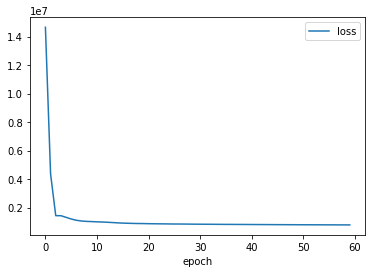

In [62]:
train_dataset = NonAddressableImputationDataset(train)
test_dataset = NonAddressableImputationDataset(test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

rbm, losses = train_reconstruction_RBM(train_loader, 
                                       train_dataset.VISIBLE_UNITS)
plot_loss(losses)
test_features = \
  generate_reconstruction(rbm,
                          test_dataset,
                          test_loader)
train_features = \
  generate_reconstruction(rbm,
                          train_dataset,
                          train_loader)

### Preliminary Evaluation: Reconstruction
- here i was not sure how to determine a cutoff probability for the imputed label. so i created one off of the distribution of reconstructed labels in the training set, 
    - frankly i am not sure whether this is a good practice or not, but figured it would give us an idea of how this performs
- overall it appears that this is not the correct approach to go with

In [ ]:
roc_auc_score(train[Y].values, train_features[:, label_idx])

In [91]:
roc_auc_score(test[Y].values, test_features[:, label_idx])

0.5348187947629118